OpenCV version: 4.10.0
Exists: asm-1.jpg True
Exists: asm-2.jpg True


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /Users/nariman/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:15<00:00, 10.5MB/s] 


Loaded torchvision Faster R-CNN with weights.
Using device: cpu


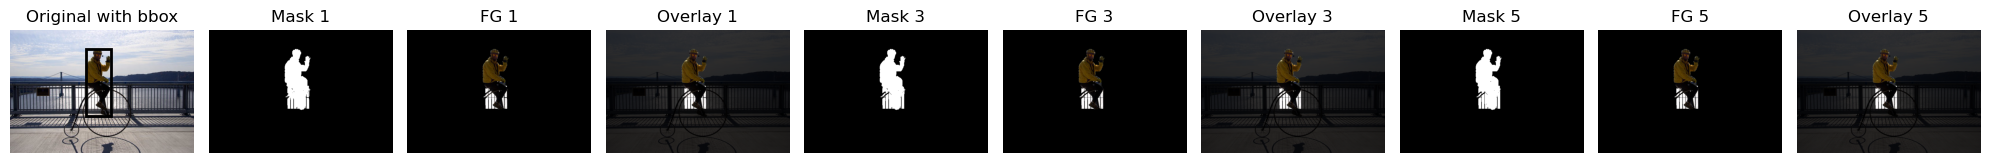

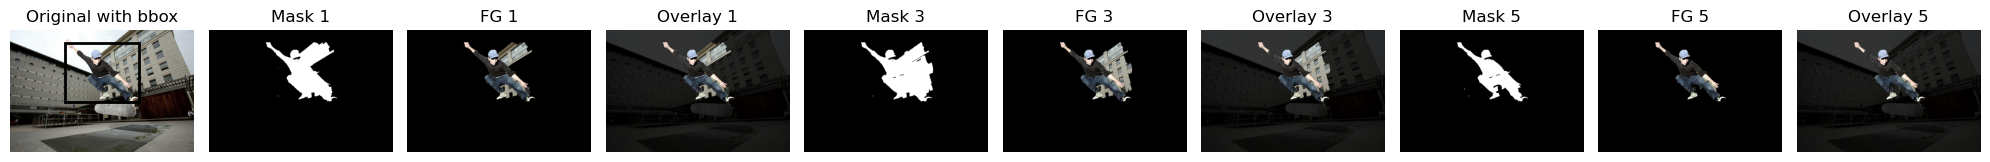

In [1]:

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

print("OpenCV version:", cv2.__version__)


img_paths = ["asm-1.jpg", "asm-2.jpg"]
for p in img_paths:
    print("Exists:", p, os.path.exists(p))

use_torch = False
model = None
try:
    import torch
    import torchvision
    from torchvision.transforms import functional as F
    try:
        weights = torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=weights)
        preprocess = weights.transforms()
        use_torch = True
        print("Loaded torchvision Faster R-CNN with weights.")
    except:
        try:
            model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
            def preprocess(img):
                img = np.array(img).astype(np.float32)/255.0
                img = torch.from_numpy(img).permute(2,0,1)
                return img
            use_torch = True
            print("Loaded torchvision Faster R-CNN (legacy API).")
        except:
            use_torch = False
except:
    use_torch = False

if use_torch and model is not None:
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print("Using device:", device)

def detect_person_torch(cv2_img, score_thresh=0.6):
    rgb = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2RGB)
    pil = Image.fromarray(rgb)
    try:
        inp = preprocess(pil)
        if isinstance(inp, dict):
            img_tensor = inp["image"].unsqueeze(0).to(device)
        else:
            if not isinstance(inp, torch.Tensor):
                inp = F.to_tensor(pil)
            img_tensor = inp.unsqueeze(0).to(device)
        with torch.no_grad():
            out = model(img_tensor)[0]
        boxes = out["boxes"].cpu().numpy()
        scores = out["scores"].cpu().numpy()
        labels = out["labels"].cpu().numpy()
        inds = np.where(labels == 1)[0]
        if len(inds)==0: return None
        best = None
        best_s = score_thresh
        for i in inds:
            if scores[i] >= best_s:
                best_s = scores[i]
                best = boxes[i]
        if best is None: return None
        x1,y1,x2,y2 = map(int, best)
        return (x1,y1,x2-x1,y2-y1,best_s)
    except:
        return None

hog = None
def detect_person_hog(cv2_img):
    global hog
    if hog is None:
        hog = cv2.HOGDescriptor()
        hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())
    img = cv2_img.copy()
    h,w = img.shape[:2]
    scale = 1.0
    if max(h,w) > 1000:
        scale = 1000 / max(h,w)
        img = cv2.resize(img, (int(w*scale), int(h*scale)))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    rects, weights = hog.detectMultiScale(gray)
    if len(rects)==0: return None
    areas = [rw*rh for (_,_,rw,rh) in rects]
    i = int(np.argmax(areas))
    x,y,rw,rh = rects[i]
    x,y,rw,rh = int(x/scale), int(y/scale), int(rw/scale), int(rh/scale)
    return (x,y,rw,rh)

detections = []
for p in img_paths:
    img = cv2.imread(p)
    det = None
    if use_torch:
        det = detect_person_torch(img)
        if det is None: print("Torch failed on", p)
    if det is None:
        det = detect_person_hog(img)
        print("HOG fallback:", p, det)
    detections.append(det)

def run_grabcut_with_rect(img_bgr, rect, iterations):
    img = img_bgr.copy()
    h,w = img.shape[:2]
    x,y,ww,hh = rect
    x=max(0,x); y=max(0,y); ww=min(ww,w-x); hh=min(hh,h-y)
    rect2=(x,y,ww,hh)
    mask = np.zeros((h,w), np.uint8)
    bgdModel = np.zeros((1,65), np.float64)
    fgdModel = np.zeros((1,65), np.float64)
    cv2.grabCut(img, mask, rect2, bgdModel, fgdModel, iterations, cv2.GC_INIT_WITH_RECT)
    mask_bin = np.where((mask==1)|(mask==3),1,0).astype('uint8')
    fg = img*mask_bin[:,:,None]
    return mask_bin, mask, fg

def bgr2rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

results=[]
for i,p in enumerate(img_paths):
    img=cv2.imread(p)
    det=detections[i]
    if det is None:
        results.append(None)
        continue
    x,y,w,h = det if len(det)==4 else det[:4]
    rect=(x,y,w,h)
    iter_results={}
    for it in [1,3,5]:
        mb, m, fg = run_grabcut_with_rect(img, rect, it)
        iter_results[it]={"mask_bin":mb,"mask":m,"foreground":fg}
    results.append({"img":img,"rect":rect,"iter_results":iter_results})

for i,res in enumerate(results):
    if res is None: continue
    img=res["img"]
    x,y,w,h=res["rect"]
    iters=[1,3,5]
    ncols=1+len(iters)*3
    plt.figure(figsize=(4*ncols/2,4))
    ax=plt.subplot(1,ncols,1)
    ax.imshow(bgr2rgb(img))
    ax.add_patch(plt.Rectangle((x,y),w,h,fill=False,linewidth=2))
    ax.set_title("Original with bbox")
    ax.axis("off")
    col=2
    for it in iters:
        mb=res["iter_results"][it]["mask_bin"]
        fg=res["iter_results"][it]["foreground"]
        ax=plt.subplot(1,ncols,col); col+=1
        ax.imshow(mb,cmap="gray"); ax.axis("off"); ax.set_title(f"Mask {it}")
        ax=plt.subplot(1,ncols,col); col+=1
        ax.imshow(bgr2rgb(fg)); ax.axis("off"); ax.set_title(f"FG {it}")
        overlay=img.copy()
        overlay[mb==0]=(overlay[mb==0]*0.2).astype("uint8")
        ax=plt.subplot(1,ncols,col); col+=1
        ax.imshow(bgr2rgb(overlay)); ax.axis("off"); ax.set_title(f"Overlay {it}")
    plt.tight_layout()
    plt.show()
